In [1]:
import os

os.system("python setup.py build_ext --inplace")

0

In [37]:
from tensorflow import keras
import tensorflow as tf
from keras_retinanet import models
import keras_retinanet
from keras_retinanet.preprocessing.trainClasse import OsuGenerator
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

sys.path.append('..')
from utilitaire.imgAiTrainer.imgAiTrainer import Trainer
tr = Trainer()

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [38]:
def generateDataSet(nb,x,y) :
    lImg = []
    lLabel = []
    lBox = []
    for j in range(nb):
        cercleT = tr.createMultiCercle((x,y),3)
        img = tf.keras.preprocessing.image.load_img("../../Assets/imgAiTrainer/cercle.png",target_size=(120,160))
        img = keras.preprocessing.image.img_to_array(img)
        lImg.append(img)
        lLabelTmp = []
        lBoxTmp = []
        box2 = np.empty((len(cercleT[0]),4))
        for i in range(len(cercleT[0])):
            box = np.zeros((4,))
            box[0] = (cercleT[0][i-1]-cercleT[3][i-1])/5
            box[1] = (cercleT[1][i-1]-cercleT[3][i-1])/5
            box[2] = (cercleT[0][i-1]+cercleT[3][i-1])/5
            box[3] = (cercleT[1][i-1]+cercleT[3][i-1])/5
            box2[i, :] = box
            #lBoxTmp.append((cercleT[0][i-1]-cercleT[3][i-1],cercleT[1][i-1]-cercleT[3][i-1],cercleT[0][i-1]+cercleT[3][i-1],cercleT[1][i-1]+cercleT[3][i-1]))
            lLabelTmp.append(0)
        lLabel.append(np.array(lLabelTmp))
        lBox.append(box2)
    lImg = np.array(lImg)
    lLabel = np.array(lLabel)
    return lImg, lBox, lLabel

In [39]:
model = models.backbone('resnet50').retinanet(num_classes=3)
#model.summary()

In [40]:
model.compile(
    loss={
        'regression'    : keras_retinanet.losses.smooth_l1(),
        'classification': keras_retinanet.losses.focal()
    },
    optimizer=keras.optimizers.Adam(lr=1e-5, clipnorm=0.001)
)
#model.summary()

In [41]:
img, box, labels = generateDataSet(1000,800,600)

In [42]:
print(box[0])
print(labels[0])
box[0].shape

[[ 67.8   9.4 112.4  54. ]
 [108.6  21.  143.6  56. ]
 [ 89.8   4.8 127.6  42.6]]
[0 0 0]


(3, 4)

In [43]:
model.load_weights('save/poids/model')
trainGenerator = OsuGenerator(img, box, labels)
model.fit_generator(
        generator = trainGenerator,
        steps_per_epoch=50,
        epochs=10,
        verbose=1
    )

Epoch 1/10
50/50 [==============================] - 19s 244us/step - loss: 7.3808e-07 - regression_loss: 0.0000e+00 - classification_loss: 7.3808e-07


In [44]:
model.save_weights('save/poids/model')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[0. 0. 0.]


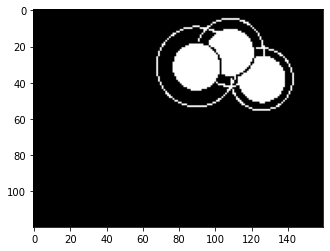

In [45]:
def show_sample(img):
  figure, axis = plt.subplots(1,1)
  axis.imshow(img)

tr = Trainer()
#cercleT = tr.createMultiCercle((800,600),3)

image = tf.keras.preprocessing.image.load_img("../../Assets/imgAiTrainer/multiCercle.png",target_size=(120,160))
image = keras.preprocessing.image.img_to_array(image)
print(image[30][65])
show_sample(image)

In [46]:
model = models.backbone('resnet50').retinanet(num_classes=3)
model.load_weights('save/poids/model')
resultat1,resultat2=model.predict_on_batch(np.expand_dims(image, axis=0))



In [47]:
print(resultat1[0][0],resultat2[0][0])

[-0.11318041  0.37042844 -0.5219214   0.18937786] [0.0008848  0.00070217 0.00110275]


In [48]:
# correct for image scale
#boxes /= scale

img = Image.open("../../Assets/imgAiTrainer/multiCercle.png")
# visualize detections
for box, label in zip(resultat1[0], resultat2[0]):
    # scores are sorted so we can break
     draw = ImageDraw.Draw(img)
     draw.rectangle([box[0],box[1],box[2],box[3]], fill=None, outline='red', width=5)
img.show()
